# INF-395/477 Redes Neuronales Artificiales I-2018
## Tarea 2 -  Redes Convolucionales y sus aplicaciones
> Juan Pablo Cruz 201473004-7

> Felipe Chacón 201303017-3

## 1. Convolutional Neural Networks (CNN) en CIFAR 

En esta sección trabajaremos con un dataset bastante conocido y utilizado por la comunidad para experimentar reconocimiento de objetos en imágenes: CIFAR10 [3]. Se trata de un conjunto de 60.000 imágenes RGB de 32 × 32 pixeles que contiene 10 clases de objetos y 6000 ejemplos por clase. La versión utilizada se le atribuye a *A. Krizhevsky, V. Nair* y *G. Hinton* y viene separada en 50000 ejemplos de entrenamiento y 10000 casos de prueba que fueron obtenidos seleccionando 1000 imágenes aleatorias de cada clase.  
Los datos restantes han sido ordenados aleatoriamente y están organizados en 5 bloques de entrenamiento o batches. Cabe destacar que las clases son mutuamente excluyentes y corresponden a las siguientes categorı́as: 

* Gato
* Perro
* Rana
* Caballo
* Pájaro
* Ciervo
* Avión
* Automóvil
* Camión 
* Barco

Para esta tarea se experimentará con redes convolucionales, conocidas como CNNs ó ConvNets.  
**Nota:** Para esta actividad es bastante aconsejable entrenar las redes usando una GPU, ya que de otro modo los tiempos de entrenamiento serán largos. Recuerde instalar Keras con gpu y el driver de cuda para la tarjeta gráfica.  

> **a)** Construya una función que cargue todos los bloques de entrenamiento y pruebas del problema CIFAR generando como salida:  
(i) dos matrices  Xtr, Ytr; correspondientes a las imágenes y etiquetas de entrenamiento  
(ii) dos matrices Xt, Yt; correspondientes a las imágenes y etiquetas de pruebas  
(iii) dos matrices Xv, Yv; correspondientes a las imágenes y etiquetas que se usarán como conjunto de validación (para tomar decisiones de diseño acerca del modelo)  

> **Este último conjunto debe ser extraı́do desde el conjunto de entrenamiento original y no debe superar las 5000 imágenes.**


In [0]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
import numpy as np
import os
import keras
from keras.optimizers import SGD, rmsprop
from keras.callbacks import LearningRateScheduler
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [0]:
from keras.datasets import cifar10

In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_val = x_train[int(0.9*x_train.shape[0]):x_train.shape[0]]
y_val = y_train[int(0.9*y_train.shape[0]):y_train.shape[0]]
x_train = x_train[0:int(0.9*x_train.shape[0])]
y_train = y_train[0:int(0.9*y_train.shape[0])]

170500096/170498071 [==============================] - 109s 1us/step


> **b)** Prepare subconjuntos de entrenamiento, validación y pruebas normalizando las imágenes de entrenamiento y pruebas, dividiendo las intensidades originales de pixel en cada canal por 255.  Es importante notar que si desea trabajar con el orden de las dimensiones denominado ’tf’ (por defecto para TensorFlow) deberá realizar la transposición correspondiente para dejar el canal en donde corresponda. Finalmente, genere una representación adecuada de las salidas deseadas de la red.

In [0]:
x_train = x_train.transpose([0, 3, 1, 2]) #only if 'tf' dim-ordering is to be used
x_test = x_test.transpose([0, 3, 1, 2]) #remove if 'th' dim-ordering is to be used
x_val = x_val.transpose([0, 3, 1, 2])
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)
y_val = keras.utils.to_categorical(y_val, 10)

In [0]:
x_train = x_train.astype("float") /255.0
x_val = x_val.astype("float") /255.0
x_test = x_test.astype("float") /255.0

> **c)** Defina una CNN con arquitectura $C \times P \times C \times P \times F \times F$. Para ambas capas convolucionales utilice 64 filtros de $3 \times 3$ y funciones de activación ReLU. Para las capas de pooling utilice filtros de $2 \times 2$ con stride 2. Para la capa MLP escondida use 512 neuronas. Genere un esquema lo más compacto posible que muestre los cambios de forma (dimensionalidad) que experimenta un patrón de entrada a medida que se ejecuta un forward-pass y el número de parámetros de cada capa.

In [0]:
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides = 2, data_format="channels_first"))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides = 2, data_format="channels_first"))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 3, 32, 64)         18496     
_________________________________________________________________
activation_23 (Activation)   (None, 3, 32, 64)         0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 3, 16, 32)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 3, 16, 64)         18496     
_________________________________________________________________
activation_24 (Activation)   (None, 3, 16, 64)         0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 3, 8, 32)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 768)               0         
__________

> **d)**  Entrene la CNN definida en **c)** utilizando SGD. En este dataset, una tasa de aprendizaje “segura” es $\eta = 10^{-4}$ o inferior, pero durante las primeras *epochs* el entrenamiento resulta demasiado lento. Para resolver el problema aprenderemos a controlar la tasa de aprendizaje utilizada en el entrenamiento. Implemente la siguiente idea: deseamos partir con una tasa de aprendizaje $\eta = 10^{-3}$ y dividir por 2 ese valor cada 10 epochs. Suponga además que no queremos usar una tasa de aprendizaje menor a $\eta = 10^{-5}$.  Construya un gráfico que muestre los errores de entrenamiento, validación y pruebas como función del número de “epochs”, entrene con 25 *epochs*.

In [0]:
class TestCallback(keras.callbacks.Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss = self.model.evaluate(x, y, verbose=0)
        testLoss.append(loss)

In [0]:
def step_decay(epoch):
    initial_lrate = 0.001
    lrate = initial_lrate * math.pow(0.5, math.floor((1+epoch)/5))
    lrate = max(lrate,0.00001)
    return lrate

In [0]:
opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
lrate = LearningRateScheduler(step_decay)
epochs = 25
batch_size = 32
testLoss = []
model.compile(opt, loss="categorical_crossentropy")
model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs, validation_data=(x_val,y_val), shuffle=True, callbacks=[lrate, TestCallback((x_test, y_test))])

Train on 45000 samples, validate on 5000 samples
Epoch 1/25
45000/45000 [==============================] - 10s 215us/step - loss: 1.9082 - val_loss: 1.6944
Epoch 2/25
45000/45000 [==============================] - 9s 200us/step - loss: 1.6133 - val_loss: 1.5588
Epoch 3/25
45000/45000 [==============================] - 9s 203us/step - loss: 1.4861 - val_loss: 1.4659
Epoch 4/25
45000/45000 [==============================] - 9s 202us/step - loss: 1.4175 - val_loss: 1.3813
Epoch 5/25
45000/45000 [==============================] - 9s 200us/step - loss: 1.3491 - val_loss: 1.3486
Epoch 6/25
45000/45000 [==============================] - 9s 205us/step - loss: 1.3201 - val_loss: 1.3171
Epoch 7/25
45000/45000 [==============================] - 9s 204us/step - loss: 1.2929 - val_loss: 1.3061
Epoch 8/25
45000/45000 [==============================] - 9s 201us/step - loss: 1.2745 - val_loss: 1.2806
Epoch 9/25
45000/45000 [==============================] - 9s 205us/step - loss: 1.2514 - val_loss: 1.2

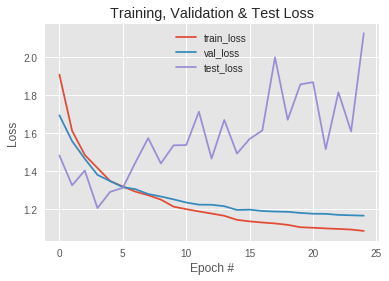

In [0]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 25), model.history.history["loss"], label="train_loss")
plt.plot(np.arange(0, 25), model.history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 25), testLossAcc[0], label="test_loss")
plt.title("Training, Validation & Test Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()

> **e)** Entrene la CNN definida en c) utilizando **RMSProp** durante 25 *epochs*. Elija la función de pérdida más apropiada para este problema. Construya finalmente un gráfico que muestre los errores de entrenamiento, validación y pruebas como función del número de *epochs*.  
*Hint: La curva sugiere algún cambio en el modelo definido, considere ésto en cuenta para las experimentaciones futuras.*

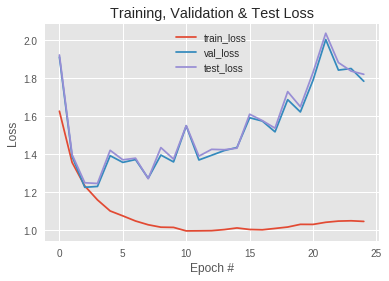

In [0]:
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides = 2, data_format="channels_first"))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides = 2, data_format="channels_first"))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))

opt = rmsprop(lr=0.001, decay=1e-6)
model.compile(opt, loss="categorical_crossentropy")
epochs = 25
batch_size = 32
testLoss = []
model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs, verbose = 0, validation_data=(x_val, y_val),shuffle=True, callbacks=[TestCallback((x_test, y_test))])

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 25), model.history.history["loss"], label="train_loss")
plt.plot(np.arange(0, 25), model.history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 25), testLoss, label="test_loss")
plt.title("Training, Validation & Test Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()

> **f)** Evalúe el efecto de modificar el tamaño de los filtros (de convolución) reportando la sensibilidad del error de pruebas a estos cambios en dos tipos de arquitecturas, una profunda y otra no. Presente un gráfico o tabla resumen. Por simplicidad entrene durante sólo 15-20 *epochs*.

In [0]:
"""Shallow network"""
testErrorsS = []
ncFilters = [3, 4, 5, 6, 7, 8, 9] #convolutional filter size
for nc in ncFilters:
  model = Sequential()
  model.add(Conv2D(64, (nc, nc), padding='same', input_shape=x_train.shape[1:]))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides = 2, data_format="channels_first"))
  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dense(10))
  model.add(Activation('softmax'))
  
  opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
  lrate = LearningRateScheduler(step_decay)
  epochs = 15
  batch_size = 32
  model.compile(opt, loss="categorical_crossentropy")
  model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs, verbose = 0, validation_data=(x_val,y_val), shuffle=True, callbacks=[lrate])
  
  testErrorsS.append(model.evaluate(x_test, y_test, verbose=0))

In [0]:
'''Deep neural network'''
testErrorsD = []
ncFilters = [3, 4, 5, 6, 7, 8, 9] #convolutional filter size
for nc in ncFilters:
  model = Sequential()
  model.add(Conv2D(64, (nc, nc), padding='same', input_shape=x_train.shape[1:]))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides = 2, data_format="channels_first"))
  model.add(Conv2D(64, (nc, nc), padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides = 2, data_format="channels_first"))
  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dense(10))
  model.add(Activation('softmax'))
  
  opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
  lrate = LearningRateScheduler(step_decay)
  epochs = 15
  batch_size = 32
  model.compile(opt, loss="categorical_crossentropy")
  model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs, verbose = 0, validation_data=(x_val,y_val), shuffle=True, callbacks=[lrate])
  
  testErrorsD.append(model.evaluate(x_test, y_test, verbose=0))


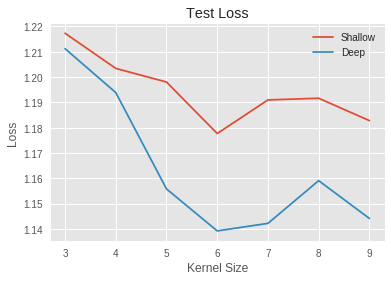

In [0]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(3, 10), testErrorsS, label="Shallow")
plt.plot(np.arange(3, 10), testErrorsD, label="Deep")
plt.title("Test Loss")
plt.xlabel("Kernel Size")
plt.ylabel("Loss")
plt.legend()

>> Se puede observar que, en la red no profunda, a mayor tamaño del kernel, menor es el _loss_ del conjunto de test, pero solo hasta un tamaño de 6x6. En la red profunda, pasa algo similar a la primera, el _loss_ va bajando hasta un tamaño de 6x6 y luego empieza a oscilar. En general, los valores de _loss_ de la red profunda son menores que la que no es profunda.

> **g)** Se ha sugerido que la práctica bastante habitual de continuar una capa convolucional con una capa de *pooling* puede generar una reducción prematura de las dimensiones del patrón de entrada. Experimente con una arquitectura del tipo $C \times P \times C \times P \times F \times F$ versus  $C \times C \times P \times C \times C \times P \times F \times F$. Use 64 filtros para la primera capa convolucional y 128 para la segunda (o 64 filtros para las primeras 2 capas convolucionales y 128 para las dos últimas).  

> Reflexione sobre qué le parece más sensato: ¿qué estructura permite un mejor desempeño y/o extracción de atributos de interés?¿es aconsejable mantener el tamaño de los filtros usados anteriormente (pregunta anterior)? o ¿usar filtros más grandes en la segunda capa convolucional y más pequeños en la primera? o ¿usar filtros más pequeños en la segunda capa convolucional y más grandes en la primera?  
> **Hint:** con esta nueva arquitectura debiese superar el 70% de accuracy (de validación/test) antes de 5 epochs, pero la arquitectura es más sensible a overfitting por lo que podrı́a ser conveniente agregar un regularizador. Como resultado final de esta actividad gráfique los errores de entrenamiento, validación y pruebas como función del número de “epochs” (fijando el máximo en un número razonable como T = 25).

In [0]:
class TestWithAccCallback(keras.callbacks.Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        testLoss.append(loss)

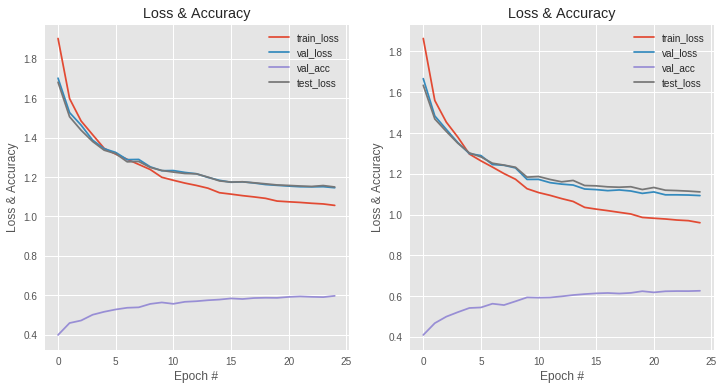

In [0]:
plt.style.use("ggplot")
plt.figure(figsize=(12,6))
  
# C×P×C×P×F×F
for i in range(1,3):
  model = Sequential()
  model.add(Conv2D(64, (3*i, 3*i), padding='same', input_shape=x_train.shape[1:]))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides = 2, data_format="channels_first"))
  model.add(Conv2D(128, (3*i, 3*i), padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides = 2, data_format="channels_first"))
  #model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dense(10))
  model.add(Activation('softmax'))

  opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
  lrate = LearningRateScheduler(step_decay)
  epochs = 25
  batch_size = 32
  testLoss = []
  model.compile(opt, loss="categorical_crossentropy", metrics=['acc'])
  model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs, verbose = 0, validation_data=(x_val,y_val), shuffle=True, callbacks=[lrate, TestWithAccCallback((x_test, y_test))])
  
  plt.subplot(1,2,i)
  plt.plot(np.arange(0, 25), model.history.history["loss"], label="train_loss")
  plt.plot(np.arange(0, 25), model.history.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, 25), model.history.history["val_acc"], label="val_acc")
  plt.plot(np.arange(0, 25), testLoss, label="test_loss")
  plt.title("Loss & Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss & Accuracy")
  plt.legend()
plt.show()

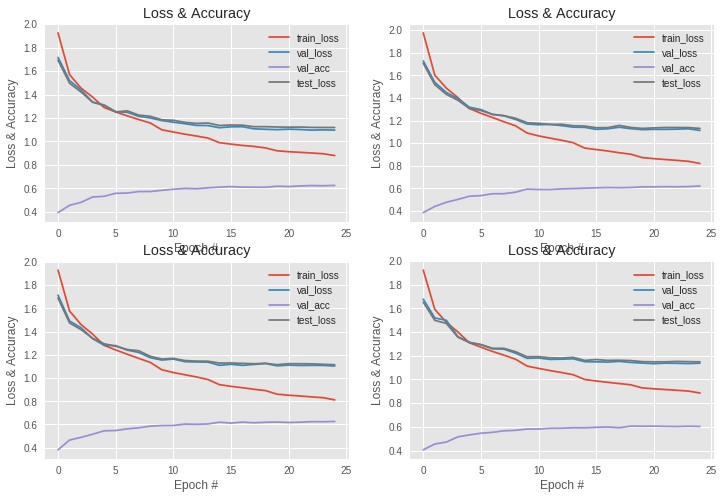

In [0]:
filters1 = [3, 6, 3, 6]
filters2 = [3, 6, 6, 3]
plt.style.use("ggplot")
plt.figure(figsize=(12,8))

# C×C×P×C×C×P×F×F
for i in range(len(filters1)):
  model = Sequential()
  model.add(Conv2D(64, (filters1[i], filters1[i]), padding='same', input_shape=x_train.shape[1:]))
  model.add(Activation('relu'))
  model.add(Conv2D(64, (filters2[i], filters2[i]), padding='same', input_shape=x_train.shape[1:]))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides = 2, data_format="channels_first"))
  model.add(Conv2D(128, (filters1[i], filters1[i]), padding='same'))
  model.add(Activation('relu'))
  model.add(Conv2D(128, (filters2[i], filters2[i]), padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides = 2, data_format="channels_first"))
  #model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dense(10))
  model.add(Activation('softmax'))

  opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
  lrate = LearningRateScheduler(step_decay)
  epochs = 25
  batch_size = 32
  testLoss = []
  model.compile(opt, loss="categorical_crossentropy", metrics=['acc'])
  model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs, verbose = 0, validation_data=(x_val,y_val), shuffle=True, callbacks=[lrate, TestWithAccCallback((x_test, y_test))])

  plt.subplot(2,2,i+1)
  plt.plot(np.arange(0, 25), model.history.history["loss"], label="train_loss")
  plt.plot(np.arange(0, 25), model.history.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, 25), model.history.history["val_acc"], label="val_acc")
  plt.plot(np.arange(0, 25), testLoss, label="test_loss")
  plt.title("Loss & Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss & Accuracy")
  plt.legend()
plt.show()

En la red con 2 capas convolucionales seguidas, el error de _training_ es más bajo, pero la _accuracy_ es muy similar a la obtenida en primera red.

Se puede ver en los gráficos que utilizando filtros más pequeños en la primera capa de convolución mejora ligeramente el desempeño, disminuyendo el error tanto en _training_ como en _validation_ y aumentando el _accuracy_.

Cuando ambas capas tienen filtros del mismo tamaño muestran un desempeño similar, pero obteniendo un mejor _accuracy_ la que tiene un mayor tamaño de 6x6.

En general, para todos los tamaños de kernel, los gráficos se comportaron de manera muy similar.


> **h)** Algunos investigadores, han propuesto que las capas de *pooling* se pueden reemplazar por capas convoluciones con stride 2. ¿Se reduce dimensionalidad de este modo? Compruébelo verificando los cambios de forma (dimensionalidad) que experimenta un patrón de entrada a medida que se ejecuta un *forward-pass*.  
Entrene la red resultante con el método que prefiera, gráficando los errores de entrenamiento, validación y pruebas como función del número de “epochs” (fijando el máximo en un número razonable como T = 25).

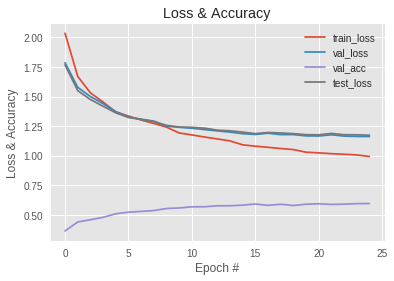

In [0]:
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(64, (2, 2), strides=(2, 2), padding='same'))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (2, 2), strides=(2, 2), padding='same'))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))

opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
lrate = LearningRateScheduler(step_decay)
epochs = 25
batch_size = 32
testLoss = []
model.compile(opt, loss="categorical_crossentropy", metrics = ['acc'])
model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs, verbose = 0, validation_data=(x_val,y_val), shuffle=True, callbacks=[lrate, TestWithAccCallback((x_test, y_test))])

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 25), model.history.history["loss"], label="train_loss")
plt.plot(np.arange(0, 25), model.history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 25), model.history.history["val_acc"], label="val_acc")
plt.plot(np.arange(0, 25), testLoss, label="test_loss")
plt.title("Loss & Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss & Accuracy")
plt.legend()

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 3, 32, 64)         18496     
_________________________________________________________________
activation_37 (Activation)   (None, 3, 32, 64)         0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 3, 32, 64)         36928     
_________________________________________________________________
activation_38 (Activation)   (None, 3, 32, 64)         0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 2, 16, 64)         16448     
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 2, 16, 128)        73856     
_________________________________________________________________
activation_39 (Activation)   (None, 2, 16, 128)        0         
__________

In [0]:
model.evaluate(x_test, y_test, verbose = 0)

[1.1727555942535401, 0.5925]

Se reduce la dimensionalidad de la imagen de entrada al pasar por las capas convolucionales que reemplazan las capas de _pooling_. Se puede observar en la tabla anterior que en vez de tener 3 canales, la imagen pasa a tener 2 y posteriormente a tener solo 1 canal.

En cuanto al desempeño comparado con una red con capas de _pooling_ como las que se encuentran en __g)__, la red con capas convolucionales es ligeramente peor que las otras, pues el gráfico ilustra que el error de validación está más cercano a $1.2$ y el _accuracy_ obtenido, de $0.59$, es más bajo que en los otros gráficos.


> **j)** Para una comparación del desempeño de la red neuronal, pre-procese el dataset de CIFAR-10 y calcule los descriptores manuales SIFT, para un mejor entendimiento de éstos consulte:  https://ianlondon.github.io/blog/how-to-sift-opencv/ y https://docs.opencv.org/3.4.3/da/df5/tutorial_py_sift_intro.html. Como se genera un descriptor de 128 dimensiones para cada *keypoint* comprima esta información de alguna manera, comente sobre la operación.

> Es necesario instalar *OpenCV* para realizar el cálculo de este descriptor.  

In [0]:
import cv2
cv2.__version__

'3.4.3'

In [0]:
!pip uninstall opencv-python

Uninstalling opencv-python-3.4.3.18:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/cv2/*
    /usr/local/lib/python3.6/dist-packages/opencv_python-3.4.3.18.dist-info/*
Proceed (y/n)? y
  Successfully uninstalled opencv-python-3.4.3.18


In [0]:
!pip install opencv-python==3.1.0.4 opencv-contrib-python==3.4.2.16

In [0]:
import cv2
def pre_process(img):
    if np.max(img) <= 1:
        img*=255
    img = img.astype("uint8")
    img_gray= cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return img_gray
  
def calculate_sift(cifar):
    sift_cifar = []
    for image in cifar:
      img_gray = pre_process(image)
      sift = cv2.xfeatures2d.SIFT_create()
      kp, desc = sift.detectAndCompute(img_gray, None)
      if type(desc) == type(None):
        desc = np.zeros((1,128))
      compress_desc = np.mean(desc,axis=0) #compress all keypoints
      sift_cifar.append(compress_desc)
    return np.asarray(sift_cifar)

In [0]:
X = x_train.transpose([0, 2, 3, 1])
cifar_sift = calculate_sift(X)

Los descriptores SIFT son

*Recuerde escalar los datos antes de entregárselos al modelo*

> **j.1)** Visualice los *keypoint* para una mejor comprensión visual de lo que son los descriptores manuales en alguna imagen aleatoria.

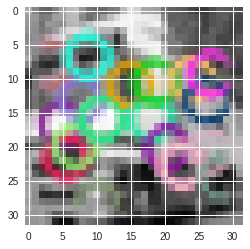

In [0]:
sample_image = X[1]
gray_sample_image = pre_process(sample_image)
sift = cv2.xfeatures2d.SIFT_create()
kp, desc = sift.detectAndCompute(gray_sample_image, None)
"""draw and plot"""
img=cv2.drawKeypoints(gray_sample_image,kp,sample_image.copy())

import matplotlib.pyplot as plt
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(desc[0].reshape(16,8), interpolation='none', cmap='viridis')

plt.show()

> Entrene una red neuronal densa (la misma que sigue a las capas convoluciones definidas en los modelos previos), compare el desempeño de la red con el modelo más básico (o de peor desempeño) y el modelo de mejor desempeño obtenido hasta este punto. Comente sobre el entrenamiento (error y tiempos de ejecución) y resultados.


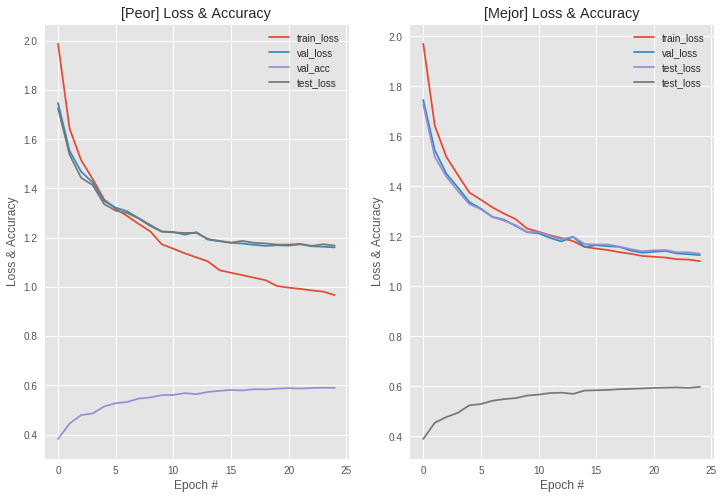

Tiempo de red con peor desempeño:  385.52856063842773
Tiempo de red con mejor desempeño:  394.42317938804626


In [0]:
import time

start1 = time.time()

model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(64, (2, 2), strides=(2, 2), padding='same'))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (2, 2), strides=(2, 2), padding='same'))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))

opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
lrate = LearningRateScheduler(step_decay)
epochs = 25
batch_size = 32
testLoss = []
model.compile(opt, loss="categorical_crossentropy", metrics = ['acc'])
model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs, verbose = 0, validation_data=(x_val,y_val), shuffle=True, callbacks=[lrate, TestWithAccCallback((x_test, y_test))])

plt.style.use("ggplot")
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.plot(np.arange(0, 25), model.history.history["loss"], label="train_loss")
plt.plot(np.arange(0, 25), model.history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 25), model.history.history["val_acc"], label="val_acc")
plt.plot(np.arange(0, 25), testLoss, label="test_loss")
plt.title("[Peor] Loss & Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss & Accuracy")
plt.legend()

end1 = time.time()
start2 = time.time()

# C×C×P×C×C×P×F×F
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides = 2, data_format="channels_first"))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides = 2, data_format="channels_first"))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))

opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
lrate = LearningRateScheduler(step_decay)
epochs = 25
batch_size = 32
testLoss = []
model.compile(opt, loss="categorical_crossentropy", metrics=['acc'])
model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs, verbose = 0, validation_data=(x_val,y_val), shuffle=True, callbacks=[lrate, TestCallback((x_test, y_test))])

plt.subplot(1,2,2)
plt.plot(np.arange(0, 25), model.history.history["loss"], label="train_loss")
plt.plot(np.arange(0, 25), model.history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 25), testLoss, label="test_loss")
plt.title("[Mejor] Loss & Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss & Accuracy")
plt.legend()
plt.show()

end2 = time.time()

print("Tiempo de red con peor desempeño: ", end1 - start1)
print("Tiempo de red con mejor desempeño: ", end2 - start2)

El error de entrenamiento es más alto en el gráfico de la derecha debido a la capa de Dropout que tiene, pero en cuanto el error de validación, este es menor al gráfico de al izquierda. Además, el _accuracy_ logrado por la red con mejor desempeño es ligeramente mejor que la otra red.
En cuanto a tiempos de ejecución, la red con mejor desempeño demoró más, pero por unos cuantos segundos, alrededor de $10$.

> **k)** Elija una de las redes entrenadas en esta sección (preferentemente una con buen desempeño) y determine los pares de objetos (por ejemplo “camiones” con “autos”) que la red tiende a confundir. Conjeture el motivo de tal confusión.

In [0]:
# C×C×P×C×C×P×F×F
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides = 2, data_format="channels_first"))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides = 2, data_format="channels_first"))
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))

opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
lrate = LearningRateScheduler(step_decay)
epochs = 25
batch_size = 32
testLoss = []
model.compile(opt, loss="categorical_crossentropy")
model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs, verbose = 0, validation_data=(x_val,y_val), shuffle=True, callbacks=[lrate])

In [0]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = model.predict(x_test, batch_size=32)

print(confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
print("-----")
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=label_names))

[[638  32  38  22  18  20  18  23 121  70]
 [ 16 732  12  11   3  10  10   9  44 153]
 [ 71  14 398  79 119  91 100  72  33  23]
 [ 20  22  52 437  56 200 104  46  25  38]
 [ 28   9 111  52 492  68 122  69  37  12]
 [ 12   9  49 177  42 538  73  56  21  23]
 [ 12  12  47  62  63  64 690  18  13  19]
 [ 33  19  53  53  60  79  19 646  10  28]
 [ 68  49   6  16  16  10   9  12 746  68]
 [ 23 144  12  17   7  17  19  19  52 690]]
-----
             precision    recall  f1-score   support

   airplane       0.69      0.64      0.66      1000
 automobile       0.70      0.73      0.72      1000
       bird       0.51      0.40      0.45      1000
        cat       0.47      0.44      0.45      1000
       deer       0.56      0.49      0.52      1000
        dog       0.49      0.54      0.51      1000
       frog       0.59      0.69      0.64      1000
      horse       0.67      0.65      0.66      1000
       ship       0.68      0.75      0.71      1000
      truck       0.61      0.69

El modelo suele confundir gatos con perros, según la matriz de confusión, se identificaron 200 gatos como perros y 177 perros como gatos.
Esto puede deberse a que ambos son animales cuadrúpedos, existen varias razas y colores para cada uno, son peludos y tienen patas. Una de las formas de poder diferenciar ambos animales, sería por el tamaño, pero este no puede ser extraído de las imágenes, pues depende de cómo se saquen las fotos el tamaño que tendrá el animal.

Además, como sale en el enunciado de esta pregunta, el modelo también confunde autos con camiones, pero en menor medida. Según la matriz de confusión, se identificaron 153 autos como camiones y 144 camiones como autos. En este caso, hay muchas similitudes entre ambos vehículos, ambos tienen ruedas, asientos, diferentes marcas y formas, por lo que la confusión del modelo tiene sentido.

Otra confusión que genera el modelo es entre tres animales, que serían las aves, las ranas y los ciervos. Pero en esta ocasión, la confusión es de las aves y los ciervos, que en ocasiones son clasificados como ranas, en otras como aves y en otras como ciervos, sin embargo, el modelo no suele confundir las ranas con aves o ciervos.

> **l)** Elija una de las redes entrenadas (preferentemente una con buen desempeño) y visualice los pesos correspondientes a los filtros de la primera capa convolucional. Visualice además el efecto del filtro sobre algunas imágenes de entrenamiento. Repita el proceso para los pesos de la última capa convolucional; Comente y compare con los descriptores SIFT.

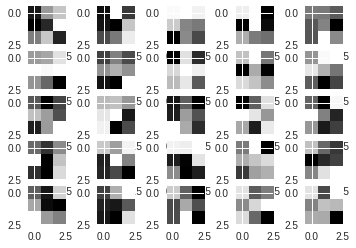

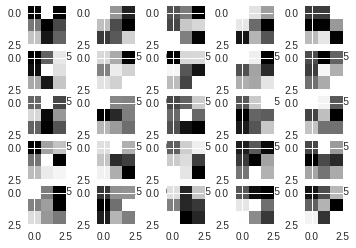

In [0]:
# Primera capa de activacion de una convolucional
x1w = model.layers[0].get_weights()[0][:,:,0,:]
for i in range(1,26):
  plt.subplot(5,5,i)
  plt.imshow(x1w[:,:,i],interpolation="nearest",cmap="gray")
plt.show()

# Ultima capa de activacion de una convolucional
x1w = model.layers[7].get_weights()[0][:,:,0,:]
for i in range(1,26):
  plt.subplot(5,5,i)
  plt.imshow(x1w[:,:,i],interpolation="nearest",cmap="gray")
plt.show()

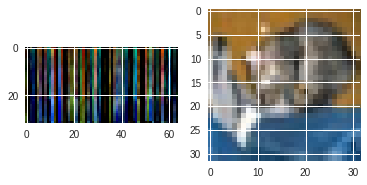

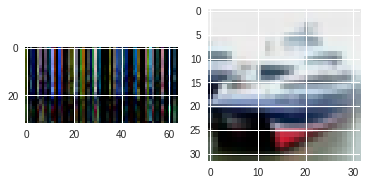

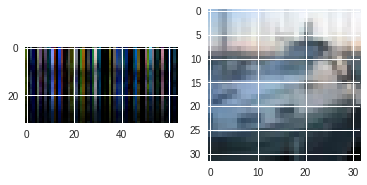

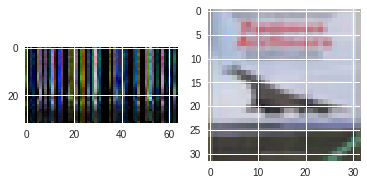

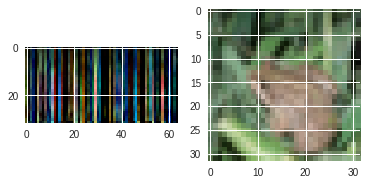

In [0]:
from keras import backend as K

inp = model.input                                           # input placeholder
outputs = [layer.output for layer in model.layers]          # all layer outputs
functor = K.function([inp, K.learning_phase()], outputs)    # evaluation function

# Testing
for i in range(0,5):
  plt.subplot(1,2,1)
  layer_out = functor([x_test[i][np.newaxis,:], 1.])[1][0]
  layer_out = layer_out.astype("float") / np.max(layer_out)
  layer_out = layer_out.transpose([1,2,0])
  plt.imshow(layer_out)

  plt.subplot(1,2,2)
  plt.imshow(x_test[i].transpose([1,2,0]))
  plt.show()

## 2. *Transfer Learning*

En esta sección se trabajará con el dataset trabajado anteriormente, CIFAR [3], pero en su versión más fina, en el cual se presentan 100 tipos distintos de categorías a clasificar la imagen (mutuamente excluyente), no 10 como se usó en las actividades anteriores. La estructura es la misma, son 60000 imágenes RGB de 32 $\times$ 32 píxeles separados en 50 mil de entrenamiento y 10 mil de pruebas.  
Aquí se experimentará con el concepto de *transfer learning* el cual consta en transferir conocimiento de un dominio fuente (*source domain*) a un dominio objetivo (*target domain*). En redes neuronales existen muchas representaciones de esto, en común consta en pre inicializar los pesos de la red de alguna manera que no sea con distribuciones de manera aleatoria (*fine tunning*). También está lo que es utilizar una representación generada a través de otra red entrenada con muchos datos, esto es tomar la red y "*congelar*" sus primeras capas para tomar esta representación y no entrenar esos pesos, lo que realizaremos en esta sección. 


In [0]:
from keras.datasets import cifar100
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,BatchNormalization
from keras.optimizers import SGD
import matplotlib.pyplot as plt
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
%matplotlib inline

Using TensorFlow backend.


Se obtienen los datos y se normalizan para que cada pixel se muevan entre $[0,1]$.

In [0]:
#Obtención de los datos y normalización de estos.
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')
y_train = keras.utils.to_categorical(y_train, num_classes=100)
y_test = keras.utils.to_categorical(y_test, num_classes=100)
x_train_norm = x_train/255.0
x_test_norm = x_test/255.0

**a)** Entrene una red neuronal convolucional como se presenta en el código a continuación durante 15 *epochs*, realizando un gráfico de evolución de la función de pérdida y de la exactitud del algoritmo (*accuracy*) sobre ambos conjuntos, entrenamiento y pruebas. Comente sobre el tiempo de ejecución de este entrenamiento. Reporte el *accuracy* del modelo final sobre el conjunto de pruebas.


In [0]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train_norm.shape[1:],activation='relu'))
model.add(Conv2D(32, (3, 3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3),padding='same',activation='relu'))
model.add(Conv2D(64, (3, 3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100,activation='softmax'))

optimizer_ = SGD(lr=0.01,momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=optimizer_, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
__________

In [0]:
#Se entrena el modelo
model.fit(x_train_norm, y_train, batch_size=128,epochs=15,verbose=1, validation_data=(x_test_norm,y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 16s 329us/step - loss: 4.3176 - acc: 0.0447 - val_loss: 3.8716 - val_acc: 0.1059
Epoch 2/15
50000/50000 [==============================] - 12s 237us/step - loss: 3.7994 - acc: 0.1199 - val_loss: 3.4967 - val_acc: 0.1796
Epoch 3/15
50000/50000 [==============================] - 12s 236us/step - loss: 3.4465 - acc: 0.1829 - val_loss: 3.1889 - val_acc: 0.2338
Epoch 4/15
50000/50000 [==============================] - 12s 239us/step - loss: 3.1230 - acc: 0.2415 - val_loss: 2.9267 - val_acc: 0.2854
Epoch 5/15
50000/50000 [==============================] - 12s 239us/step - loss: 2.8545 - acc: 0.2924 - val_loss: 2.7352 - val_acc: 0.3249
Epoch 6/15
50000/50000 [==============================] - 12s 240us/step - loss: 2.6093 - acc: 0.3417 - val_loss: 2.6197 - val_acc: 0.3429
Epoch 7/15
50000/50000 [==============================] - 12s 238us/step - loss: 2.3933 - acc: 0.3844 - val_loss: 2.

El entrenamiento de este modelo fue ejecutado en el entorno virtual de $Colaboratory - Google$, el que cuenta con una gran cantidad de recursos y el uso de tarjetas gráficas , en donde se tardó aproximadamente **3 minutos** en completar todo el entrenamiento. Además, se realizó este entrenamiento en un computador sin hacer uso de una tarjeta gráfica, dando un tiempo cercano a **60 minutos** en completar el entrenamiento de la red. Así se puede ver el efecto que genera en el tiempo de ejecución del entrenamiento el hacer uso de una tarjeta gráfica, lo que disminuye notablemente el tiempo.

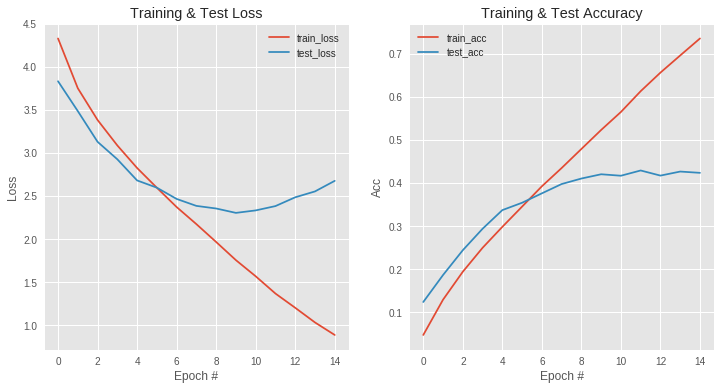

In [0]:
#Gráficos de loss y accuracy durante el entrenamiento del modelo
plt.style.use("ggplot")
plt.figure()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(np.arange(0, 15), model.history.history["loss"], label="train_loss")
plt.plot(np.arange(0, 15), model.history.history["val_loss"], label="test_loss")
plt.title("Training & Test Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
 
plt.subplot(1,2,2)
plt.plot(np.arange(0, 15), model.history.history["acc"], label="train_acc")
plt.plot(np.arange(0, 15), model.history.history["val_acc"], label="test_acc")
plt.title("Training & Test Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Acc")
plt.legend()

In [0]:
#accuracy final
print("El accuracy final obtenido en el conjunto de test es: %f" %model.history.history["val_acc"][-1])

El accuracy final obtenido en el conjunto de test es: 0.423300


Al observar los gráficos, principalmente el de Loss, se puede ver  como el test_loss disminuye hasta la Epoch 9 y luego comienza a aumentar mientras que el train_loss disminuye constantemente. Si consideramos solamente hasta la Epoch 15, lo anterior significaría que esta ocurriendo overfitting, por lo que se debe buscar alguna forma de mejorar la capacidad de generalización del modelo.

**b)** Debido al comportamiento de las curvas de entrenamiento, claramente se ve que se necesita un regularizador. Experimente utilizando Dropout con una tasa de 0.25 en las tandas convolucionales, elija donde situarlo, luego de la primera convolución, después de la segunda, solamente después del *pooling*, en todas o alguna forma que le parezca conveniente, de argumentos de ello. La idea es que se forme una idea de dónde conviene colocar el regularizador y porqué.

Se entrenará el modelo utilizado en **a)** con la implementación de Dropout. Se probarán las 3 siguientes configuraciones de Dropout: 


A.   Dropout luego de la primera capa de convolución.

B.   Dropout luego de la segunda capa de convolución.

C.  Dropout luego del *pooling*.


In [0]:
#A) Dropout luego de la primera capa de convolucion
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train_norm.shape[1:],activation='relu'))
model.add(Dropout(0.25))
model.add(Conv2D(32, (3, 3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3),padding='same',activation='relu'))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100,activation='softmax'))
optimizer_ = SGD(lr=0.01,momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=optimizer_, metrics=['accuracy'])
model.fit(x_train_norm, y_train, batch_size=128,epochs=15,verbose=1, validation_data=(x_test_norm,y_test))

#B) Dropout luego de la segunda capa de convolucion
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train_norm.shape[1:],activation='relu'))
model2.add(Conv2D(32, (3, 3),padding='same',activation='relu'))
model2.add(Dropout(0.25))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Conv2D(64, (3, 3),padding='same',activation='relu'))
model2.add(Conv2D(64, (3, 3),padding='same',activation='relu'))
model2.add(Dropout(0.25))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Flatten())
model2.add(Dense(1024,activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(100,activation='softmax'))
optimizer_ = SGD(lr=0.01,momentum=0.9)
model2.compile(loss='categorical_crossentropy', optimizer=optimizer_, metrics=['accuracy'])
model2.fit(x_train_norm, y_train, batch_size=128,epochs=15,verbose=1, validation_data=(x_test_norm,y_test))

#C) Dropout luego de cada pooling
model3 = Sequential()
model3.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train_norm.shape[1:],activation='relu'))
model3.add(Conv2D(32, (3, 3),padding='same',activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))
model3.add(Conv2D(64, (3, 3),padding='same',activation='relu'))
model3.add(Conv2D(64, (3, 3),padding='same',activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))
model3.add(Flatten())
model3.add(Dense(1024,activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(100,activation='softmax'))
optimizer_ = SGD(lr=0.01,momentum=0.9)
model3.compile(loss='categorical_crossentropy', optimizer=optimizer_, metrics=['accuracy'])
model3.fit(x_train_norm, y_train, batch_size=128,epochs=15,verbose=1, validation_data=(x_test_norm,y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 15s 295us/step - loss: 4.3693 - acc: 0.0418 - val_loss: 3.9868 - val_acc: 0.1067
Epoch 2/15
50000/50000 [==============================] - 14s 282us/step - loss: 3.8643 - acc: 0.1080 - val_loss: 3.8500 - val_acc: 0.1234
Epoch 3/15
50000/50000 [==============================] - 14s 282us/step - loss: 3.6087 - acc: 0.1531 - val_loss: 3.7612 - val_acc: 0.1469
Epoch 4/15
50000/50000 [==============================] - 14s 281us/step - loss: 3.3946 - acc: 0.1908 - val_loss: 3.2740 - val_acc: 0.2280
Epoch 5/15
50000/50000 [==============================] - 14s 280us/step - loss: 3.1716 - acc: 0.2316 - val_loss: 3.0643 - val_acc: 0.2664
Epoch 6/15
50000/50000 [==============================] - 14s 280us/step - loss: 2.9707 - acc: 0.2709 - val_loss: 2.8931 - val_acc: 0.2956
Epoch 7/15
50000/50000 [==============================] - 14s 281us/step - loss: 2.7956 - acc: 0.3023 - val_loss: 2.

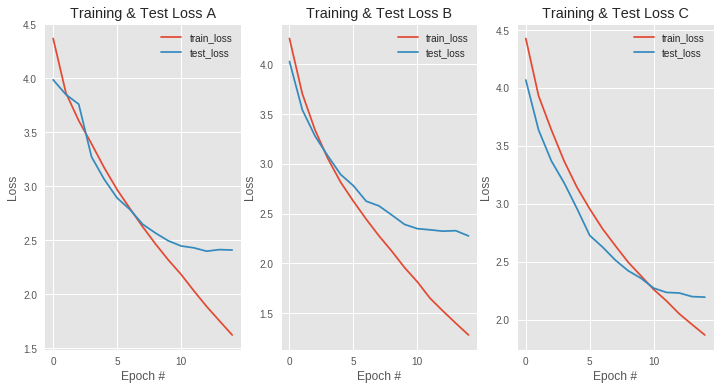

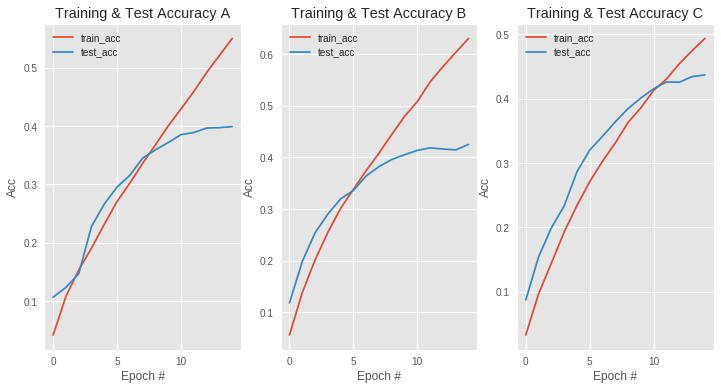

In [0]:
#Gráficos de Loss y Accuracy de los 3 modelos
plt.style.use("ggplot")
plt.figure()
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.plot(np.arange(0, 15), model.history.history["loss"], label="train_loss")
plt.plot(np.arange(0, 15), model.history.history["val_loss"], label="test_loss")
plt.title("Training & Test Loss A")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
 
plt.subplot(1,3,2)
plt.plot(np.arange(0, 15), model2.history.history["loss"], label="train_loss")
plt.plot(np.arange(0, 15), model2.history.history["val_loss"], label="test_loss")
plt.title("Training & Test Loss B")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,3,3)
plt.plot(np.arange(0, 15), model3.history.history["loss"], label="train_loss")
plt.plot(np.arange(0, 15), model3.history.history["val_loss"], label="test_loss")
plt.title("Training & Test Loss C")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()

plt.figure()
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.plot(np.arange(0, 15), model.history.history["acc"], label="train_acc")
plt.plot(np.arange(0, 15), model.history.history["val_acc"], label="test_acc")
plt.title("Training & Test Accuracy A")
plt.xlabel("Epoch #")
plt.ylabel("Acc")
plt.legend()

plt.subplot(1,3,2)
plt.plot(np.arange(0, 15), model2.history.history["acc"], label="train_acc")
plt.plot(np.arange(0, 15), model2.history.history["val_acc"], label="test_acc")
plt.title("Training & Test Accuracy B")
plt.xlabel("Epoch #")
plt.ylabel("Acc")
plt.legend()

plt.subplot(1,3,3)
plt.plot(np.arange(0, 15), model3.history.history["acc"], label="train_acc")
plt.plot(np.arange(0, 15), model3.history.history["val_acc"], label="test_acc")
plt.title("Training & Test Accuracy C")
plt.xlabel("Epoch #")
plt.ylabel("Acc")
plt.legend()

In [0]:
#accuracy finales
print("El accuracy final del modelo A obtenido en el conjunto de test es: %f" %model.history.history["val_acc"][-1])
print("El accuracy final del modelo B obtenido en el conjunto de test es: %f" %model2.history.history["val_acc"][-1])
print("El accuracy final del modelo C obtenido en el conjunto de test es: %f" %model3.history.history["val_acc"][-1])

El accuracy final del modelo A obtenido en el conjunto de test es: 0.399200
El accuracy final del modelo B obtenido en el conjunto de test es: 0.425200
El accuracy final del modelo C obtenido en el conjunto de test es: 0.437000


Observando los gráficos obtenidos de los modelos, se puede ver que, si bien, el modelo C entrega el mejor accuracy final, no es un valor notablemente distinto al obtenido en los otros 2 modelos por lo que no es posible considerarlo como principal criterio para identificar en donde colocar el Dropout. Pero al ver las curvas en los gráficos, se puede ver como el modelo C tiene en ambos gráficos las curvas de train y de test bastante cercanas durante las 15 Epoch, a diferencia de los modelos A y B en donde los resultados de *test* a medida que se avanza en las Epoch, mejoran menos que en el conjunto de *train*, lo que es una señal de que esta empezando a generarse overfitting. De esta forma, se concluye que es mejor colocar Dropout luego de realizar *pooling*, esto podría deberse a que, antes de realizar un *pooling*, se tiene una cierta cantidad de caracteristicas extraidas de la capa anterior y luego de realizar el *pooling* estas caracteristicas se comprimen en un menor número de neuronas, por lo que al realizar un Dropout en este lugar provoca que al apagar una neurona, se este apagando una mayor cantidad de caracteristicas, lo que mejora la generalización del modelo.

**c)** Una forma de hacer lo que se conoce como *transfer learning* es utilizar el conocimiento (los parámetros) aprendido por una red entrenada con millones de imágenes, y tomar estos parámetros como los pre entrenados. Para esto se utilizará el modelo VGG16 [7] proporcionado a través de la interfaz de *keras*. Visualice el modelo y sus 23 capas. Para esta instancia se utilizará todo lo aprendido por las capas convolucionales, es decir, se eliminan las capas densas del modelo y se agregan unas nuevas a ser entrenadas desde cero.  
*Recuerde normalizar los datos de la manera en que fue entrenado VGG* ¿Cuál es éste proceso?


Para esta parte se hará uso del modelo VGG16, por lo que se tiene que preprocesar las imagenes para que tengan el mismo formato de las utilizadas en VGG16, para esto se utiliza la funcion *preprocess_input()*, la que modifica cada pixel restandole a sus 3 canales los valores: $[103.939, 116.779, 123.68]$

In [0]:
x_train_vgg = preprocess_input(x_train)
x_test_vgg = preprocess_input(x_test)
input_tensor=keras.engine.input_layer.Input(shape=x_train_vgg.shape[1:])
modelVGG = VGG16(weights='imagenet', include_top=False,input_tensor=input_tensor )
features_train = modelVGG.predict(x_train_vgg)
features_test = modelVGG.predict(x_test_vgg)
modelVGG.summary()

58892288/58889256 [==============================] - 2s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool

Si bien, este modelo cuenta con 23 capas, al utilizar solamente las capas convolucionales esta cantidad disminuye, por lo que el modelo a utilizar consta de 19 capas que recibe una imagen de tamaño 32x32x3 y que entregará una salida de tamaño 1x1 con una profundidad de 512. 

**d)** Entrene esta red agregando una capa densa de 1024 neuronas seguido de un dropout de 0.5, finalmente es necesario agregar la capa de clasificación para las 100 clases. Utilice la misma configuración del optimizador para que las comparaciones sean válidas. Entrene unicamente por 10 *epochs* y grafique las curvas de entrenamiento con respecto al modelo definido en a) o con regularización definido en b) ¿Qué sucede? Comente.


In [0]:
model = Sequential()
model.add(Flatten(input_shape=features_train.shape[1:]))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100,activation='softmax'))
optimizer_ = SGD(lr=0.01,momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=optimizer_, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               102500    
Total params: 627,812
Trainable params: 627,812
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.fit(features_train, y_train,epochs=10, batch_size=128,verbose=1,validation_data=(features_test,y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 3s 56us/step - loss: 14.5279 - acc: 0.0901 - val_loss: 14.3691 - val_acc: 0.1045
Epoch 2/10
50000/50000 [==============================] - 2s 47us/step - loss: 14.4204 - acc: 0.1028 - val_loss: 14.3783 - val_acc: 0.1058
Epoch 3/10
50000/50000 [==============================] - 2s 47us/step - loss: 14.3216 - acc: 0.1098 - val_loss: 14.2112 - val_acc: 0.1165
Epoch 4/10
50000/50000 [==============================] - 2s 48us/step - loss: 14.3321 - acc: 0.1093 - val_loss: 14.3803 - val_acc: 0.1065
Epoch 5/10
50000/50000 [==============================] - 3s 50us/step - loss: 14.4015 - acc: 0.1053 - val_loss: 14.5442 - val_acc: 0.0965
Epoch 6/10
50000/50000 [==============================] - 2s 49us/step - loss: 14.3768 - acc: 0.1072 - val_loss: 14.3308 - val_acc: 0.1102
Epoch 7/10
50000/50000 [==============================] - 2s 48us/step - loss: 14.3779 - acc: 0.1069 - val_loss: 14.

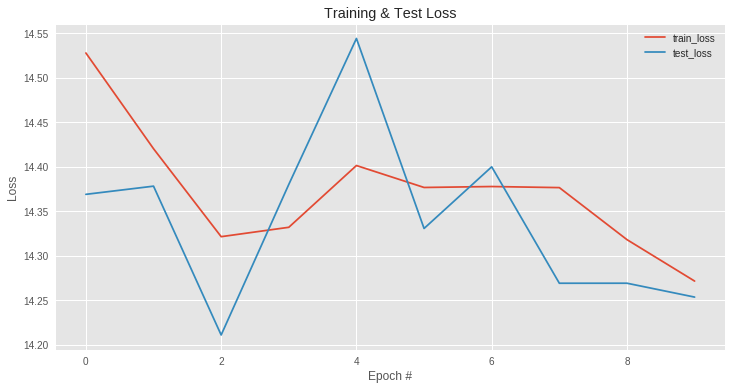

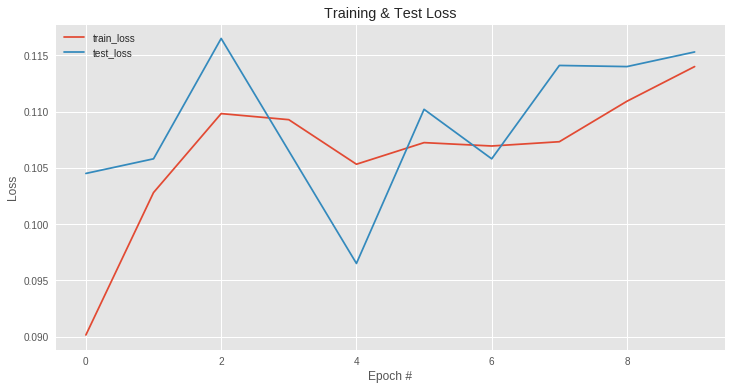

In [0]:
plt.style.use("ggplot")
plt.figure()
plt.figure(figsize=(12,6))
plt.plot(np.arange(0, 10), model.history.history["loss"], label="train_loss")
plt.plot(np.arange(0, 10), model.history.history["val_loss"], label="test_loss")
plt.title("Training & Test Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()

plt.style.use("ggplot")
plt.figure()
plt.figure(figsize=(12,6))
plt.plot(np.arange(0, 10), model.history.history["acc"], label="train_acc")
plt.plot(np.arange(0, 10), model.history.history["val_acc"], label="test_acc")
plt.title("Training & Test Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()


Al observar los gráficos se pueden ver unas curvas bastate irregulares en comparación a las obtenidas en **a)** y en **b**. Estas curvas, que si bien, presentan una tendencia a disminuir en el caso de Loss y a aumentar en Accuracy, presentan una oscilación a medida que avanzan las Epoch. Además los resultados obtenidos son bastante más bajos que en los modelos anteriores, obteniendo un accuracy en la Epoch 10 de aproximadamente 0.115 en el conjunto de *test*.

**e)** Agregue una capa de normalización (*Batch Normalization* [8]) de las activaciones en las capas densas, esto es, restar por la media del batch y dividir por la desviación estándar. Vuelva a entrenar el modelo con la misma configuración pero ahora por **15 *epochs***. Comente lo observado y compare las curvas de convergencia con los modelos anteriores ¿Por qué esto mejora a lo presentado en e)? Realice los mismos gráficos que en a) a través del número de *epochs* y comente sobre el tiempo de ejecución de este entrenamiento.


In [0]:
model = Sequential()
model.add(Flatten(input_shape=features_train.shape[1:]))
model.add(BatchNormalization())
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(100,activation='softmax'))
optimizer_ = SGD(lr=0.01,momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=optimizer_, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              525312    
_________________________________________________________________
batch_normalization_2 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               102500    
Total params: 633,956
Trainable params: 630,884
Non-trainable params: 3,072
_________________________________________________________________


In [0]:
model.fit(features_train, y_train,epochs=15, batch_size=128,verbose=1,validation_data=(features_test,y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 4s 81us/step - loss: 3.3059 - acc: 0.2720 - val_loss: 2.4431 - val_acc: 0.3856
Epoch 2/15
50000/50000 [==============================] - 4s 75us/step - loss: 2.4736 - acc: 0.3790 - val_loss: 2.2856 - val_acc: 0.4124
Epoch 3/15
50000/50000 [==============================] - 4s 75us/step - loss: 2.2556 - acc: 0.4131 - val_loss: 2.2436 - val_acc: 0.4274
Epoch 4/15
50000/50000 [==============================] - 4s 76us/step - loss: 2.1174 - acc: 0.4382 - val_loss: 2.2191 - val_acc: 0.4279
Epoch 5/15
50000/50000 [==============================] - 4s 75us/step - loss: 2.0118 - acc: 0.4587 - val_loss: 2.1957 - val_acc: 0.4395
Epoch 6/15
50000/50000 [==============================] - 4s 76us/step - loss: 1.9369 - acc: 0.4747 - val_loss: 2.1905 - val_acc: 0.4397
Epoch 7/15
50000/50000 [==============================] - 4s 75us/step - loss: 1.8638 - acc: 0.4887 - val_loss: 2.1816 - val_acc

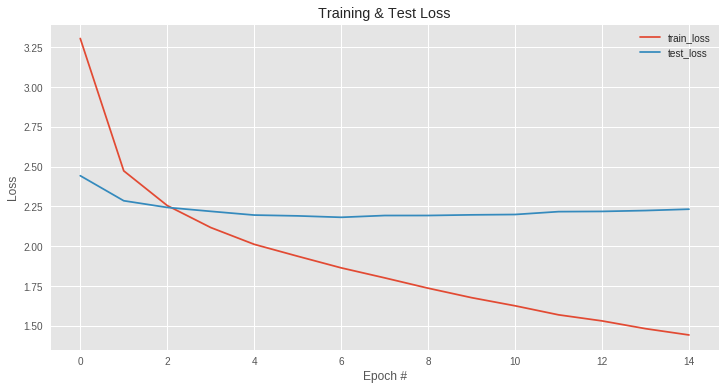

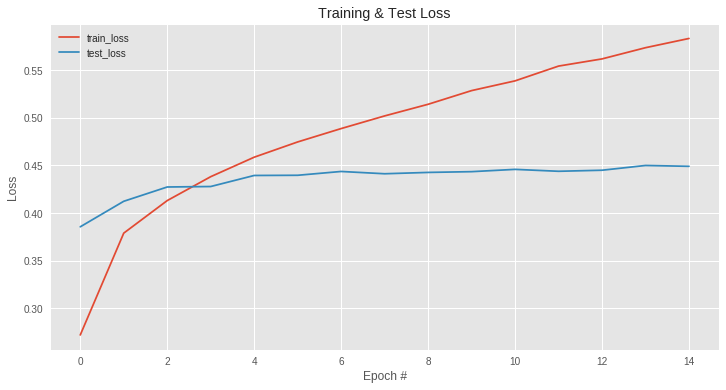

In [0]:
plt.style.use("ggplot")
plt.figure()
plt.figure(figsize=(12,6))
plt.plot(np.arange(0, 15), model.history.history["loss"], label="train_loss")
plt.plot(np.arange(0, 15), model.history.history["val_loss"], label="test_loss")
plt.title("Training & Test Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()

plt.style.use("ggplot")
plt.figure()
plt.figure(figsize=(12,6))
plt.plot(np.arange(0, 15), model.history.history["acc"], label="train_loss")
plt.plot(np.arange(0, 15), model.history.history["val_acc"], label="test_loss")
plt.title("Training & Test Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()

Observando los gráficos se puede ver como ahora las curvas se parecen a las obtenidas en **a)** y en **b)**, con un accuracy semejante al obtenido en estos modelos, a diferencia con el modelo utilizado en **d)**, en donde los resultados eran bastate peores que los obtenidos aca. Esto se debe al uso de *Batch Normalization*, el que además de funcionar en parte como un regularizador y mejorar la generalización del modelo, esto ocurre ya que, reduce la *internal covariance shift*.

**f)** Finalmente experimente con utilizar toda la red pre-entrenada, eliminando la capa de clasificación de mil neuronas de VGG reemplazandola por la capa de clasificación para su modelo (o con alguna capa extra si estima conveniente), dejando "congelada" toda la red para atrás, ésto quiere decir que utilizará la representación generada por la última capa (no de clasificación) de la red VGG, ésto es las capas densas, no la convolucional como en la parte c). Grafique las curvas de entrenamiento (función de pérdida/*loss*) , comparando con b) y e).


In [0]:
!pip install opencv-python==3.1.0.4 opencv-contrib-python==3.4.2.16
import cv2 as cv

Como se piensa utilizar todo el modelo VGG16 (exceptuando la capa de clasificación), que debe recibir como entrada una imagen de tamaño 224x224, se debe hacer un pre-procesamiento de las imagenes para escalarlas de 32x32 a 224x224. Por temas de limitaciones de memoria en el entorno virtual en el que se trabaja, no es posible utilizar las 60000 imagenes, por lo que se tiene que reducir el número a 6000 (5000 de training y 1000 de test).

In [0]:
x_train_resize = np.empty([5000,224,224,3])
for image in range(0,5000):
  x_train_resize[image] = (cv.resize(x_train[image], (224, 224)))

In [0]:
x_test_resize = np.empty([1000,224,224,3])
for image in range(0,1000):
  x_test_resize[image] = (cv.resize(x_test[image], (224, 224)))

In [0]:
x_train_vgg = preprocess_input(np.asarray(x_train_resize))
x_test_vgg = preprocess_input(np.asarray(x_test_resize))
input_tensor=keras.engine.input_layer.Input(shape=x_train_vgg.shape[1:])
modelVGG = VGG16(weights='imagenet', include_top=True,input_tensor=input_tensor )  
modelVGG.layers.pop() 
modelVGG.summary()
features_train = modelVGG.predict(x_train_vgg)
features_test = modelVGG.predict(x_test_vgg)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Se añaden las capas finales de clasificación junto con un *batchNormalization y dropout*.

In [0]:
model = Sequential()
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(100,activation='softmax'))
optimizer_ = SGD(lr=0.01,momentum=0.9)
model.compile(optimizer=optimizer_,loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(features_train,y_train[:5000],epochs=15,batch_size=128,verbose=1,validation_data=(features_test,y_test[:1000]))

Train on 5000 samples, validate on 1000 samples
Epoch 1/15
5000/5000 [==============================] - 1s 124us/step - loss: 4.5800 - acc: 0.0368 - val_loss: 4.4148 - val_acc: 0.1080
Epoch 2/15
5000/5000 [==============================] - 0s 50us/step - loss: 4.3046 - acc: 0.1188 - val_loss: 4.1370 - val_acc: 0.2150
Epoch 3/15
5000/5000 [==============================] - 0s 46us/step - loss: 4.0668 - acc: 0.1876 - val_loss: 3.9158 - val_acc: 0.2580
Epoch 4/15
5000/5000 [==============================] - 0s 46us/step - loss: 3.8708 - acc: 0.2114 - val_loss: 3.7488 - val_acc: 0.2770
Epoch 5/15
5000/5000 [==============================] - 0s 48us/step - loss: 3.7383 - acc: 0.2428 - val_loss: 3.6198 - val_acc: 0.2940
Epoch 6/15
5000/5000 [==============================] - 0s 45us/step - loss: 3.6275 - acc: 0.2652 - val_loss: 3.5129 - val_acc: 0.3050
Epoch 7/15
5000/5000 [==============================] - 0s 46us/step - loss: 3.5123 - acc: 0.2720 - val_loss: 3.4168 - val_acc: 0.3170
Epoch 

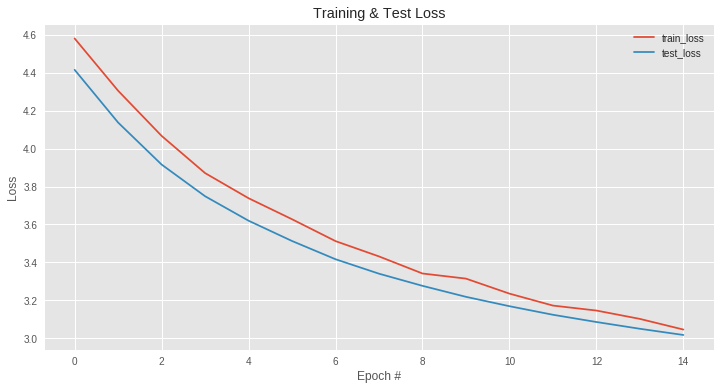

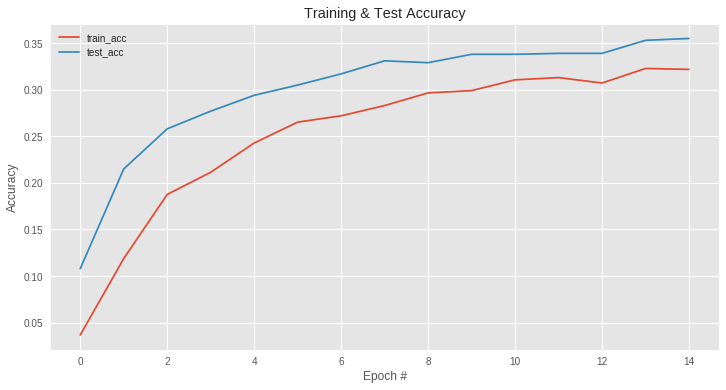

In [0]:
plt.style.use("ggplot")
plt.figure()
plt.figure(figsize=(12,6))
plt.plot(np.arange(0, 15), model.history.history["loss"], label="train_loss")
plt.plot(np.arange(0, 15), model.history.history["val_loss"], label="test_loss")
plt.title("Training & Test Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()

plt.style.use("ggplot")
plt.figure()
plt.figure(figsize=(12,6))
plt.plot(np.arange(0, 15), model.history.history["acc"], label="train_acc")
plt.plot(np.arange(0, 15), model.history.history["val_acc"], label="test_acc")
plt.title("Training & Test Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()

Debido a que en esta ocasión se debió entrenar el modelo con 5000 imagenes mientras que en los modelos anteriores se utilizaron 50000, no resulta posible hacer una comparación justa entre estos. Aún así, se puede ver que el modelo llega a un accuracy en el conjunto de *test* de aproximadamente 0.35, lo que deberia ser mucho mayor si se utilizara todo el conjunto de imagenes, por lo que se esperaría que los resultados obtenidos fuesen bastante buenos  y mejores o porlomenos parecidos a los obtenidos en los anteriores modelos.

**g)** ¿Cuándo podría ser útil y cuando no utilizar *transfer learning* o una red pre-entrenada?

Utilizar *transfer learning* resulta útil cuando se cuenta con poca data etiquetada y con una red pre-entrenada con un gran número de data, pero con la condición de que la tarea a desempeñar en ambas redes debe ser semejante, si las tareas no tienen relación alguna, entonces este método no servirá.

También resulta útil cuando, si bien, se cuenta con una gran cantidad de data etiquetada, se busca un tiempo de entrenamiento rápido manteniendo buenos resultados, lo que se puede lograr a traves de este método al tener que entrenar solamente las últimas capas de la red.

## 3. CNN sobre texto

Cuando oimos sobre redes neuronales convolucionales (CNN) normalmente pensamos en visión artificial. Las CNN fueron responsables de los principales avances en la clasificación de imágenes y son el núcleo de la mayoría de los sistemas de *Computer Vision* en la actualidad, desde el etiquetado automático de fotos de Facebook hasta los autos que conducen por sí mismos.

Más recientemente, también hemos empezado a aplicar CNN a problemas de procesamiento del lenguaje natural (NLP) y hemos obtenido resultados interesantes. Como sabemos, las redes convolucionales tienen importantes ventajas como invarianza a rotaciones y traslaciones así como la conectividad local (características de nivel inferior en una representación de nivel superior), además de lo que las hace fuertemente ventajosas, el **compartir** parámetros.


**¿Cómo se aplica esto a NLP?**  
En esta experimentación apicaremos una red CNN al dataset  __[Adzuna](https://www.kaggle.com/c/job-salary-prediction)__ que contiene cientos de miles de registros que en su mayoría corresponden a texto no estructurado versus sólo unos pocos estructurados. Los registros pueden estar en varios formatos diferentes debido a los cientos de diferentes fuentes de registros, los cuales corresponden a anuncios de empleadores en busca de trabajadores.  
Es decir, cada fila es un anuncio que, en estricto rigor, representa una sentencia típicamente trabajada como vectores de word embeddings como **word2vec** o **GloVe**. Así, para una frase de 10 palabras bajo representaciones de *embeddings* utilizando 100 dimensiones tendríamos una matriz de 10 × 100 como entrada, lo que simularía nuestra "imagen".


Su tarea es entonces, predecir el salario (valor continuo) de un determinado anuncio en base al texto indicado en éste. Igualmente puede valerse de otros atributos del anuncio como por ejemplo la ubicación, tipo de contrato, etc. 


A continuación se presenta un código de guía para leer los archivos y pre-procesarlos. Deberá añadir y realizar lo que estime conveniente.
```python
import pandas as pd
import numpy as np
import re, os, sys
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
stoplist = stopwords.words('english')
#lemmatizer (WordNetLemmatizer())
#stemming?

df=pd.read_csv("Train_rev1.csv")
df.head()

def pre_procesar(df):
    #preprocesar texto de los anuncios
    #Eliminación de stopwords, stemming/lemmatization, puntuación, etc
    for s in textos:
        s= s.lower()
        s= re.sub(r'[^\w]', ' ',s)
        s= re.sub(r'\b[a-z]\b', ' ',  s)
        s= re.sub(r'\b[a-z][a-z]\b', ' ',  s)
        s=re.sub(r'\b[0-9]\b', ' ',  s)
        s=re.sub(r'\b[0-9][0-9]\b', ' ',  s)
        s=re.sub(r'\b[0-9][0-9][0-9]\b', ' ',  s)
        s= re.sub(r'[^\w.]', ' ', s)
        s= list(s.split())
        #s= eliminación de stopwords
        #s= stemming o lemmatization
        #guardar texto procesado
        
    return df_procesado 
  ```
 
```python
y_dataframe=df['SalaryNormalized'].values
x_dataframe=df[['FullDescription',...]]

k=len(df_procesado)
x_train=df_procesado[0:int(k*0.70)] #70% training
x_val=df_procesado[int(k*0.70):int(k*0.85)] #15% validation
x_test=df_procesado[int(k*0.85):] #15% test
```

### Embeddings 

En lugar de entrenar nuestros vectores embeddings utilizaremos el archivo __[Glove](https://www.kaggle.com/terenceliu4444/glove6b100dtxt#glove.6B.100d.txt)__ el cual cuenta con las representaciones vectoriales (de dimensionalidad 100) ya entrenadas sobre una amplia base de datos. Puede encontrar más detalle en https://nlp.stanford.edu/projects/glove/

```python
##armar diccionario word, index para posterior construccion de matriz de embeddings de glove
word_index=dict()
j=0
for frase in x_train:
    seq=frase.split()
    for term in seq:
        if term not in word_index.keys():
            word_index[term]=j
            j+=1
            

embeddings_index = {}
f = open(os.path.join('glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Se encontraron %s terminos con sus vectores de embedding.' % len(embeddings_index))


embedding_vector=100
embedding_matrix = np.zeros((len(word_index.keys()), embedding_vector))   #puede probar otra inicialización

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words sin match en Glove, serán vectores de ceros.
        embedding_matrix[i] = embedding_vector    
        
```
### Modelo

```python
"""Definir input para el modelo: """
from keras.preprocessing import sequence
x_new_train = [[word_index[word] for word in text.split()] for text in x_train]
x_new_val = [[word_index[word] for word in text.split() if word in word_index] for text in x_val]

max_input_lenght = 150 #modificar este valor en base a su experimentación
Xtrain = sequence.pad_sequences(x_new_train,maxlen=max_input_lenght,padding='post',value=0)
Xval = sequence.pad_sequences(x_new_val,maxlen=max_input_lenght,padding='post',value=0)

"""Define model trough Model API in Keras"""
from keras.layers import Embedding
from keras.layers import Conv1D, MaxPooling1D
embedding_vector=100
embedding_layer = Embedding(input_dim=len(word_index.keys()),output_dim=embedding_vector,weights=[embedding_matrix],
                     input_length=max_input_lenght,trainable=False)

sequence_input = Input(shape=(max_input_lenght,))
embedded_sequences = embedding_layer(sequence_input)
cov1= Conv1D(128, 5, activation='relu',padding='same')(embedded_sequences)
pool = MaxPooling1D(pool_size=)(cov1)
...
flat = Flatten()(layerK)
preds = Dense(1, activation='linear')(flat)
model = Model(sequence_input, preds)
model.summary()

model.compile(loss='mse',optimizer='rmsprop',metrics=['acc'])
model.fit(Xtrain, y_train, validation_data=(Xval, y_val),epochs=25, batch_size=256)
```
### Evaluación de predicciones
Para las predicciones evalúe la métrica *Mean Absolute Error* (MAE)

```python
from sklearn.metrics import mean_absolute_error
print("MAE on train: ",mean_absolute_error(y_train, model.predict(Xtrain)))
print("MAE on validation: ",mean_absolute_error(y_val, model.predict(Xval)))
```

> **Intente resolver el problema experimentando con las ayudas que se entregan en el código y lo aprendido hasta ahora en el curso. Se espera que llegue a un MAE menor a 7000 en el conjunto de pruebas. No olvide documentar todo lo experimentando en este Informe Jupyter así como el argumento de sus decisiones.**

In [0]:
import pandas as pd
import numpy as np
import re, os, sys
import keras
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,BatchNormalization
from keras.optimizers import SGD
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer
import nltk
nltk.download('stopwords')
stoplist = stopwords.words('english')

Using TensorFlow backend.


Se leen los datos del archivo Train_rev1.csv, se extrae la columna SalaryNormalized para usarla como valor a predecir.

In [0]:
df=pd.read_csv("Train_rev1.csv",engine='python',encoding='utf-8',error_bad_lines=False)
df.head()

y_dataframe=df.pop('SalaryNormalized')
x_dataframe=df

Se define una función para preprocesar cada una de las muestras de datos. Para esto se pasan a minusculas todas las palabras y se eliminan todos los caracteres no alfanuméricos(excluyendo al ".").

In [0]:
def pre_procesar(df):
    fin = []
    for s in df:
        if(type(s) is str):
            s= s.lower()   #todo a minuscula
            s= re.sub(r'[^\w.]', ' ', s) #eminima caracteres no alfanumericos excepto el .
            s= list(s.split()) #separa todas las palabras obtenidas en una lista
            for word in s:
                fin.append(word)
        else:
            fin.append(str(s))
    return fin 

Se preprocesa toda la data disponible y luego se separa en un *70%* de *train*, *15%* de *validación* y un *15%* de *test*.

In [0]:

x_preprocesada = []

for data in x_dataframe.values[]:
    x_preprocesada.append(pre_procesar(data))
    

#x_preprocesada es un arreglo con cada dato(secuencia de palabras)
k = len(x_preprocesada)
x_train = x_preprocesada[0:int(k*0.70)] #70% training
x_val = x_preprocesada[int(k*0.70):int(k*0.85)] #15% validation
x_test = x_preprocesada[int(k*0.85):] #15% test

y_train = y_dataframe[0:int(k*0.70)] #70% training
y_val = y_dataframe[int(k*0.70):int(k*0.85)] #15% validation
y_test = y_dataframe[int(k*0.85):] #15% test

Se crea un diccionario con todas las palabras que aparecen en la data. Luego, utilizando **Glove**, se crea una matriz en donde cada fila es una de las palabras de la data en una representación vectorial.

In [0]:
#Se crea un dicionario con todas las palabras que aparecen y un numero de posicion
word_index=dict()
j=0
for frase in x_train:
    for term in frase:
        if term not in word_index.keys():
            word_index[term]=j
            j+=1

#Se cargan todas las palabras con su vector correspondiente
embeddings_index = {}
f = open(os.path.join('glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Se encontraron %s terminos con sus vectores de embedding.' % len(embeddings_index))


embedding_vector=100
embedding_matrix = np.zeros((len(word_index.keys()), embedding_vector))   #puede probar otra inicialización
#Se genera la matriz con las palabras que se tienen en la data en su forma de vector
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words sin match en Glove, serán vectores de ceros.
        embedding_matrix[i] = embedding_vector 

Se define el modelo a utilizar.

In [0]:
"""Definir input para el modelo: """
from keras.preprocessing import sequence
x_new_train = [[word_index[word] for word in text] for text in x_train]
x_new_val = [[word_index[word] for word in text if word in word_index] for text in x_val]
x_new_test = [[word_index[word] for word in text if word in word_index] for text in x_test]

max_input_lenght = 150 #modificar este valor en base a su experimentación
Xtrain = sequence.pad_sequences(x_new_train,maxlen=max_input_lenght,padding='post',value=0)
Xval = sequence.pad_sequences(x_new_val,maxlen=max_input_lenght,padding='post',value=0)
Xtest = sequence.pad_sequences(x_new_test,maxlen=max_input_lenght,padding='post',value=0)

"""Define model trough Model API in Keras"""
from keras.layers import Embedding
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import InputLayer, Input

embedding_vector=100
embedding_layer = Embedding(input_dim=len(word_index.keys()),output_dim=embedding_vector,weights=[embedding_matrix],
                     input_length=max_input_lenght,trainable=False)

sequence_input = Input(shape=(max_input_lenght,))
embedded_sequences = embedding_layer(sequence_input)
cov1= Conv1D(128, 5, activation='relu',padding='same')(embedded_sequences)
pool = MaxPooling1D(pool_size=5)(cov1)
cov2 = Conv1D(128, 5, activation='relu')(pool)
pool3 = MaxPooling1D(35)(cov2)  # global max pooling
flat = Flatten()(pool3)
preds = Dense(1, activation='linear')(flat)
model = Model(sequence_input, preds)
model.summary()

Se entrena el modelo

In [0]:
model.compile(loss='mse',optimizer='rmsprop',metrics=['acc'])
model.fit(Xtrain, y_train, validation_data=(Xval, y_val),epochs=25, batch_size=256)

Finalmente se entrega una métrica del error obtenido en cada conjunto.

In [0]:
from sklearn.metrics import mean_absolute_error
print("MAE on train: ",mean_absolute_error(y_train, model.predict(Xtrain)))
print("MAE on validation: ",mean_absolute_error(y_val, model.predict(Xval)))
print("MAE on test: ",mean_absolute_error(y_test, model.predict(Xtest)))